In [7]:
import pandas as pd
import numpy as np
import math
import vowpalwabbit
import json

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [8]:
def get_cost(true_action, predicted_action):
    return abs(true_action - predicted_action)

In [9]:
argument_string_list = ["month",  # 0
                        "day_type",  # 1
                        "hour",  # 2
                        "outdoor_dry_bulb",  # 3
                        # "outdoor_dry_bulb_temperature_predicted_6h",  # 4
                        # "outdoor_dry_bulb_temperature_predicted_12h",  # 5
                        # "outdoor_dry_bulb_temperature_predicted_24h",  # 6
                        "outdoor_relative_humidity",  # 7
                        # "outdoor_relative_humidity_predicted_6h",  # 8
                        # "outdoor_relative_humidity_predicted_12h",  # 9
                        # "outdoor_relative_humidity_predicted_24h",  # 10
                        # "diffuse_solar_irradiance",  # 11
                        # "diffuse_solar_irradiance_predicted_6h",  # 12
                        # "diffuse_solar_irradiance_predicted_12h",  # 13
                        # "diffuse_solar_irradiance_predicted_24h",  # 14
                        # "direct_solar_irradiance",  # 15
                        # "direct_solar_irradiance_predicted_6h",  # 16
                        # "direct_solar_irradiance_predicted_12h",  # 17
                        # "direct_solar_irradiance_predicted_24h",  # 18
                        # "carbon_intensity",  # 19
                        "non_shiftable_load",  # 20
                        "solar_generation",  # 21
                        "electrical_storage_soc",  # 22
                        "net_electricity_consumption", # 23
                        # "electricity_pricing",  # 24
                        # "electricity_pricing_predicted_6h",  # 25
                        # "electricity_pricing_predicted_12h",  # 26
                        # "electricity_pricing_predicted_24h",  # 27
                        ]

In [10]:
def to_vw_example_format(context, cats_label=None):
    example_dict = {}
    if cats_label is not None:
        chosen_temp, cost, pdf_value = cats_label
        example_dict["_label_ca"] = {
            "action": chosen_temp,
            "cost": cost,
            "pdf_value": pdf_value,
        }

        temp = {}

        for arg in argument_string_list:
            temp[(arg + "={}").format(context[arg])] = 1

        example_dict["c"] = temp

    return json.dumps(example_dict)

In [11]:
def predict_action(vw, context):
    vw_text_example = to_vw_example_format(context)
    return vw.predict(vw_text_example)

In [12]:
import os.path as osp
import vwmab
context_path = osp.join(osp.dirname(vwmab.__file__), "context.csv")
context = pd.read_csv(context_path)

context = pd.concat([context] * 10, ignore_index=True)

print(context)

context_target = context["action"]
context_data = context.drop(argument_string_list + ["action"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(context_data, context_target, test_size=0.2, random_state=42)

X_train = X_train.to_dict(orient="records")
y_train = np.asarray(y_train)

X_test = X_test.to_dict(orient="records")
y_test = np.asarray(y_test)

reward_rate = []
hits = 0
cost_sum = 0.0

iterations = len(X_train)

num_actions = 10
bandwidth = 0.05

# Instantiate VW learner
vw = vowpalwabbit.Workspace(
    "--cats "
    + str(num_actions)
    + "  --bandwidth "
    + str(bandwidth)
    + " --min_value -1 --max_value 1 --json --chain_hash --coin --epsilon 0.2 -q :: --quiet"
)

for index, current_context in enumerate(X_train):

    if (index + 1) % 100 == 0:
        print(index + 1)

    current_action = y_train[index]

    predicted_action, pdf_value = predict_action(vw, current_context)

    cost = get_cost(current_action, predicted_action)

    if cost <= 0.05:
        hits += 1

    cost_sum += cost

    txt_ex = to_vw_example_format(context, cats_label=(predicted_action, cost, pdf_value))

    vw_format = vw.parse(txt_ex, vowpalwabbit.LabelType.CONTINUOUS)

    vw.learn(vw_format)

    vw.finish_example(vw_format)

    reward_rate.append(cost_sum / index + 1)

vw.finish()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Team Epoch A\\Documents\\Epoch III\\citylearn-2022-starter-kit\\vwmab\\context.csv'

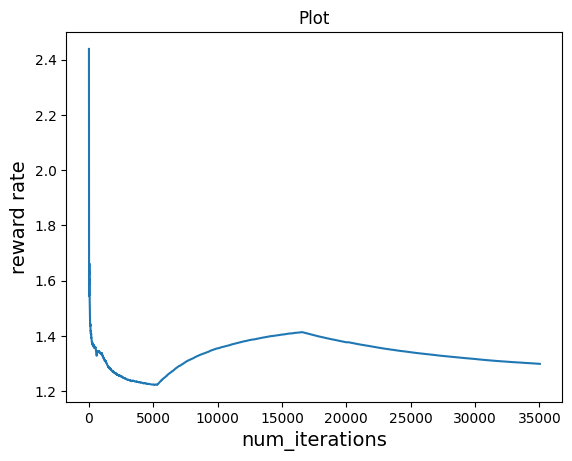

0.29945457401131903


In [38]:
plt.plot(range(1, iterations + 1), reward_rate)
plt.xlabel("num_iterations", fontsize=14)
plt.ylabel("reward rate", fontsize=14)
plt.title("Plot")
#plt.ylim([0, 1])

plt.show()

print(cost_sum / iterations)